In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
     print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 3060


In [10]:
import pandas as pd
import torch
import numpy as np
import time
import datetime
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report

In [ ]:
# --- Configuration & Hyperparameters ---
MODEL_NAME = './local-bert-base-uncased'
# This now points to the folder containing all your dataset CSVs
DATASET_DIRECTORY = './datasets/'
MAX_LEN = 256
BATCH_SIZE = 16
# You can increase this for better performance if your dataset is large
EPOCHS = 3
LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
# ----------------------------------------

# --- Device Setup ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

def load_and_standardize_datasets(path):
    """
    Loads all CSV files from a directory, standardizes their columns and labels,
    combines them, removes duplicates, and shuffles the result.
    """
    all_files = glob.glob(os.path.join(path, "*.csv"))
    if not all_files:
        print(f"Error: No CSV files were found in the directory '{path}'.")
        print("Please make sure your CSV files are inside the 'datasets' folder.")
        exit()

    print(f"Found {len(all_files)} dataset files to process...")

    df_list = []
    for filename in all_files:
        try:
            # Attempt to load with common encodings
            df = pd.read_csv(filename, encoding='latin-1')

            # --- Standardize Column Names ---
            column_rename_map = {
                'v1': 'label', 'v2': 'text',
                'Category': 'label', 'Message': 'text',
                'CLASS': 'label', 'CONTENT': 'text'
            }
            df = df.rename(columns=lambda c: c.strip().lower()).rename(columns=column_rename_map)

            if 'label' not in df.columns or 'text' not in df.columns:
                print(f"--> Skipping file: '{os.path.basename(filename)}'. Could not find required 'label' and 'text' columns.")
                continue

            df = df[['label', 'text']]

            # --- Standardize Labels ---
            label_map = {
                'ham': 0, 'spam': 1,
                '0': 0, '1': 1,
                'normal': 0,
                'legitimate': 0
            }
            df['label'] = df['label'].astype(str).str.lower().map(label_map)

            df.dropna(inplace=True)
            df['label'] = df['label'].astype(int)

            df_list.append(df)
            print(f"--> Successfully loaded and processed '{os.path.basename(filename)}', adding {len(df)} rows.")

        except Exception as e:
            print(f"--> Error processing file '{os.path.basename(filename)}': {e}")

    if not df_list:
        print("\nError: No data could be loaded from any of the files. Exiting.")
        exit()

    master_df = pd.concat(df_list, ignore_index=True)
    print(f"\nTotal combined rows: {len(master_df):,}")

    master_df.drop_duplicates(subset=['text'], inplace=True)
    print(f"Rows after removing duplicate text entries: {len(master_df):,}")

    master_df = master_df.sample(frac=1).reset_index(drop=True)
    print("Final dataset shuffled and ready for training.")

    return master_df

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060


In [14]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
# 1. Load and Prepare Data
print("\n--- Step 1: Loading and Preparing Data ---")
df = load_and_standardize_datasets(DATASET_DIRECTORY)

sentences = df.text.values
labels = df.label.values

# 2. Tokenization
print(f"\n--- Step 2: Tokenizing Data ---")
print(f"Loading BERT tokenizer from local path: '{MODEL_NAME}'...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=MAX_LEN,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


--- Step 1: Loading and Preparing Data ---
Found 4 dataset files to process...
--> Skipping file: 'data-augmented.csv'. Could not find required 'label' and 'text' columns.
--> Skipping file: 'sms_spam.csv'. Could not find required 'label' and 'text' columns.
--> Skipping file: 'SMS_Text.csv'. Could not find required 'label' and 'text' columns.
--> Successfully loaded and processed 'spam_sms.csv', adding 5572 rows.

Total combined rows: 5,572
Rows after removing duplicate text entries: 5,169
Final dataset shuffled and ready for training.

--- Step 2: Tokenizing Data ---
Loading BERT tokenizer from local path: './local-bert-base-uncased'...


In [16]:
# 3. Create Datasets and DataLoaders
print("\n--- Step 3: Creating DataLoaders ---")
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size:,} training samples')
print(f'{val_size:,} validation samples')

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)


--- Step 3: Creating DataLoaders ---
4,652 training samples
517 validation samples


In [ ]:
# 4. Load Pre-trained Model
print(f"\n--- Step 4: Loading Pre-trained Model ---")
print(f"Loading pre-trained BERT model from local path: '{MODEL_NAME}'...")
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)

# 5. Setup Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./local-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Step 4: Loading Pre-trained Model ---
Loading pre-trained BERT model from local path: './local-bert-base-uncased'...


In [18]:
# 6. Training Loop
print("\n--- Step 5: Starting Training ---")
total_t0 = time.time()
training_stats = []

for epoch_i in range(0, EPOCHS):
    print(f"\n======== Epoch {epoch_i + 1} / {EPOCHS} ========")
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels, return_dict=True)
        loss = result.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels, return_dict=True)

        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


--- Step 5: Starting Training ---

======== Epoch 1 / 3 ========
Training...
  Batch    40  of    291.    Elapsed: 0:00:17.
  Batch    80  of    291.    Elapsed: 0:00:33.
  Batch   120  of    291.    Elapsed: 0:00:49.
  Batch   160  of    291.    Elapsed: 0:01:05.
  Batch   200  of    291.    Elapsed: 0:01:20.
  Batch   240  of    291.    Elapsed: 0:01:36.
  Batch   280  of    291.    Elapsed: 0:01:52.

  Average training loss: 0.09
  Training epoch took: 0:01:56

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    291.    Elapsed: 0:00:15.
  Batch    80  of    291.    Elapsed: 0:00:31.
  Batch   120  of    291.    Elapsed: 0:00:47.
  Batch   160  of    291.    Elapsed: 0:01:02.
  Batch   200  of    291.    Elapsed: 0:01:18.
  Batch   240  of    291.    Elapsed: 0:01:34.
  Batch   280  of    291.    Elapsed: 0:01:49.

  Average training loss: 0.02
  Training epoch took: 0:01:53

Runni

In [35]:
# --- Step 7: Final Prediction and Accuracy Calculation ---
print("\n--- Step 7: Evaluating on Validation Set ---")

# Put the model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

# --- Process Predictions and Calculate Metrics ---

# Combine the results from all batches
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

# Calculate the accuracy
accuracy = np.sum(predicted_labels == flat_true_labels) / len(flat_true_labels)
print(f"\nTotal Accuracy: {accuracy:.4f}")

# Generate a detailed classification report
print("\nClassification Report:")
# Use target_names to label the classes in the report
print(classification_report(flat_true_labels, predicted_labels, target_names=['Ham (Class 0)', 'Spam (Class 1)']))


--- Step 7: Evaluating on Validation Set ---
    DONE.

Total Accuracy: 0.9903

Classification Report:
                precision    recall  f1-score   support

 Ham (Class 0)       0.99      1.00      0.99       443
Spam (Class 1)       0.97      0.96      0.97        74

      accuracy                           0.99       517
     macro avg       0.98      0.98      0.98       517
  weighted avg       0.99      0.99      0.99       517



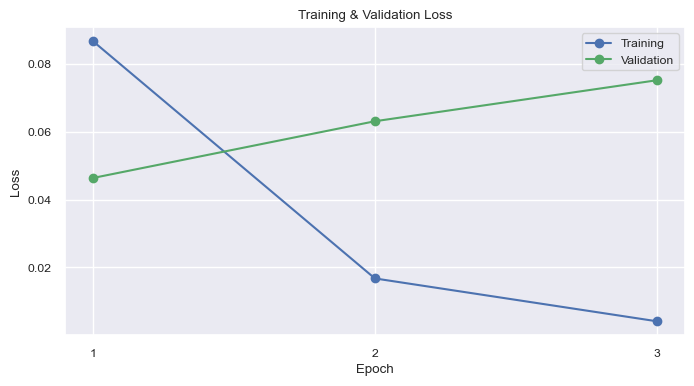

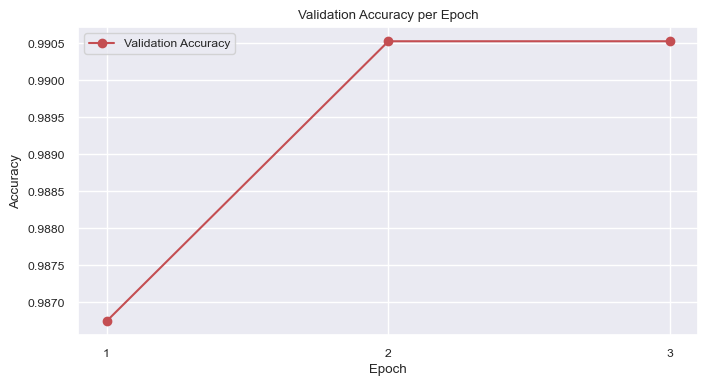

In [36]:
# --- Step 8: Plotting training statistics ---
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=0.8)
plt.rcParams["figure.figsize"] = (8,4)

# Plot the learning curve for Loss.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1, EPOCHS + 1)])
plt.show()


# Plot the learning curve for Accuracy.
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")

# Label the plot.
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([i for i in range(1, EPOCHS + 1)])
plt.show()

In [21]:
# --- Step 9: Saving Final Model ---
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving final model to {output_dir}")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print("Save complete.")

Saving final model to ./model_save/
Save complete.


In [43]:
# File: predict_notebook.py (Adapted for Jupyter)

import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

# --- Configuration ---
# Path to the directory where the fine-tuned model is saved
MODEL_PATH = './model_save/'

# IMPORTANT: This must be the same MAX_LEN that you used during training.
# In the notebook provided, this value was 256.
MAX_LEN = 256

# --- Main Prediction Function ---
def predict_spam(text):
    """
    Loads the fine-tuned model and tokenizer to predict if a text is spam or ham.
    """
    # --- Device Setup ---
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    # --- Load Tokenizer and Model ---
    try:
        tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
        model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
    except Exception as e:
        print(f"Error loading model/tokenizer: {e}")
        print("Please make sure the 'model_save' directory exists and contains the fine-tuned model.")
        return None

    # Move the model to the selected device
    model.to(device)

    # Set the model to evaluation mode. This turns off layers like Dropout.
    model.eval()

    # --- Preprocess the Input Text ---
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',  # Return PyTorch tensors
    )

    # Move tensors to the same device as the model
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    # --- Make a Prediction ---
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs.logits

    # --- Process the Output ---
    probabilities = F.softmax(logits, dim=1).cpu().numpy()[0]
    prediction_index = torch.argmax(logits, dim=1).item()
    labels = ['Ham', 'Spam']
    prediction = labels[prediction_index]

    # Return a dictionary with the results
    return {
        'prediction': prediction,
        'confidence': {
            'ham': f"{probabilities[0]*100:.2f}%",
            'spam': f"{probabilities[1]*100:.2f}%"
        }
    }

# --- Example Usage in the Notebook ---

# 1. Define the sentence you want to test
test_sentence_spam = "Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प्रविष्टि में. पाठ FAO को 87121 में प्रविष्टि प्राप्त करने के लिए(stibook दर) TTVERVE है 0. 08375750818 के मूल्य लागू करता है"

# 2. Call the prediction function
result = predict_spam(test_sentence_spam)

# 3. Print the results in a clean format
if result:
    print(f"Analyzing text: \"{test_sentence_spam}\"")
    print("-" * 30)
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence:")
    print(f"  - Ham:  {result['confidence']['ham']}")
    print(f"  - Spam: {result['confidence']['spam']}")
    print("-" * 30)

Analyzing text: "Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प्रविष्टि में. पाठ FAO को 87121 में प्रविष्टि प्राप्त करने के लिए(stibook दर) TTVERVE है 0. 08375750818 के मूल्य लागू करता है"
------------------------------
Prediction: Spam
Confidence:
  - Ham:  1.58%
  - Spam: 98.42%
------------------------------
